In [1]:
import sys
module_path = os.path.abspath(os.path.join('..'))
print(module_path)
if module_path not in sys.path:
    sys.path.append(module_path)

/home/jovyan/work/src


In [2]:
module_path = os.path.abspath(os.path.join('..'))
for dir in os.listdir('../'):
    path = module_path + '/' + dir
    sys.path.append(path)

In [3]:
!ls /datasets/kth_action | wc -l
dataset_dir = '/datasets/kth_action' # for deepnote TODO change

600


### Load dataset and model

In [4]:
import sys
sys.path.append('../')

from data.datasets import KTHDataset, SplitDataset
from network import stgcn
import torch
from torch import optim, nn, utils, autograd
from torch.utils.data import DataLoader, RandomSampler
from pathlib import Path
from data.util import loopy_pad_collate_fn
from data.augmentation import augment_data

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

config = {
    'dataset_dir': Path(dataset_dir),
    'metadata_file': Path(dataset_dir) / 'metadata.csv',
    'batch_size': 8,
    'n_epochs': 20,
    'nr_classes': 6,
    'device': device,
    'C_in': 2,  # number of input channels
    'gamma': 9,  # temporal convolution kernel size
    'edge_importance_weighting': True  # whether to use edge importance weighting
}
"""
Initialise dataset and network.

Parameters:
    config:  map containing relevant parameters
"""
batch_size = config['batch_size']
# TODO specifiy indices here instead of using sampler
train_dataset = KTHDataset(config['metadata_file'], config['dataset_dir'], use_confidence_scores=False, apply_transforms=True)
val_dataset = KTHDataset(config['metadata_file'], config['dataset_dir'], use_confidence_scores=False, apply_transforms=False)
test_dataset = KTHDataset(config['metadata_file'], config['dataset_dir'], use_confidence_scores=False, apply_transforms=False)


''' Train, val, test split'''
splitDataset = SplitDataset(config['metadata_file'])
train_indices, val_indices, test_indices = splitDataset.split()

# generate samplers using indices from filtering

train_sampler = RandomSampler(train_dataset)
val_sampler = RandomSampler(test_dataset)
test_sampler = SubsetRandomSampler(test_indices)

train_loader = DataLoader(train_dataset, batch_size=config['batch_size'], sampler=train_sampler, collate_fn=util.loopy_pad_collate_fn)
val_loader = DataLoader(val_dataset, batch_size=config['batch_size'], sampler=val_sampler, collate_fn=util.loopy_pad_collate_fn)
test_loader = DataLoader(test_dataset, batch_size=config['batch_size'], sampler=test_sampler, collate_fn=loopy_pad_collate_fn)


# load model
model = stgcn.STGCN(config['C_in'], config['gamma'], config['nr_classes'], edge_importance=config['edge_importance_weighting'])
model.to(config['device'])
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.01)

#### Train model 

In [6]:
autograd.set_detect_anomaly(True) # enable anomaly detection TODO @amrita remove for debugging purposes only

# train
# smooth loss?
val_losses = []
train_losses = []
for epoch in range(config['n_epochs']):
    for batch_idx, ((train_data, train_labels), (val_data, val_labels)) in enumerate(zip(train_loader, val_loader)):
        if batch_idx == len(train_dataset) // 2:
            break

        train_data, train_labels = train_data.to(config['device']), train_labels.to(config['device'])  # Move to GPU
        val_data, val_labels = val_data.to(config['device']), val_labels.to(config['device'])  # Move to GPU

        optimizer.zero_grad() # pytorch accumulates gradients on every call to loss.backward() so need to 0 gradients to get correct parameter update
        output = model.forward(train_data.float())

        loss = criterion(output, train_labels)

        output_val = model.forward(val_data.float())
        loss_val = criterion(output, val_labels)

        # TODO @amrita need to double check this is okay, needed for when edge importance weighting is used
        if batch_idx == 0:
            loss.backward(retain_graph = True)
        else:
            loss.backward()  # Backward pass
        optimizer.step()  # Update the weights

        train_losses.append(loss)
        val_losses.append(loss_val)

        if batch_idx == config['batch_size'] - 1:
            break
    if epoch % 10 == 0:
            print('Epoch: ', epoch + 1, '\t training loss: ', loss,  '\t validation loss: ', loss_val)

print('Saving model...')
# save model (important! just in case CUDA runs out of memory later on in testing)
torch.save(model.state_dict(), '../../models/model_no_augmentation.pt')
print('Done.')

In [ ]:
# load model back in
model = stgcn.STGCN(config['C_in'], config['gamma'], config['nr_classes'], edge_importance=config['edge_importance_weighting'])
model.load_state_dict(torch.load('../../models/model_no_augmentation.pt'))
model.to(device)

STGCN(
  (Masks): ParameterList(
      (0): Parameter containing: [torch.cuda.FloatTensor of size 1x25x25 (GPU 0)]
      (1): Parameter containing: [torch.cuda.FloatTensor of size 1x25x25 (GPU 0)]
      (2): Parameter containing: [torch.cuda.FloatTensor of size 1x25x25 (GPU 0)]
      (3): Parameter containing: [torch.cuda.FloatTensor of size 1x25x25 (GPU 0)]
      (4): Parameter containing: [torch.cuda.FloatTensor of size 1x25x25 (GPU 0)]
      (5): Parameter containing: [torch.cuda.FloatTensor of size 1x25x25 (GPU 0)]
      (6): Parameter containing: [torch.cuda.FloatTensor of size 1x25x25 (GPU 0)]
      (7): Parameter containing: [torch.cuda.FloatTensor of size 1x25x25 (GPU 0)]
      (8): Parameter containing: [torch.cuda.FloatTensor of size 1x25x25 (GPU 0)]
      (9): Parameter containing: [torch.cuda.FloatTensor of size 1x25x25 (GPU 0)]
  )
  (conv): Sequential(
    (0): SpatialTemporalConv(
      (batch_n): BatchNorm2d(2, eps=1e-05, momentum=0.1, affine=True, track_running_stats=T

### Test model on test set

In [ ]:
# get prediction

preds = []
gt_labels = []

model = model.eval() # sets dropout and batch normalisatin layers to evaluation mode before running inference


for batch_idx, (test_data, test_labels) in enumerate(test_loader):
    test_data, test_labels = test_data.to(device), test_labels.to(device)
    pred = model.forward(test_data.float())
    pred = torch.argmax(pred, axis=1)
    preds.append(pred.cpu().numpy())
    gt_labels.append(test_labels.cpu().numpy())

preds = [p for batch in preds for p in batch]
lbls = [l for batch in gt_labels for l in batch]


In [ ]:
from sklearn.metrics import confusion_matrix, accuracy_score
import seaborn as sn
import pandas as pd
import matplotlib.pyplot as plt

def plot_confusion_matrix(ground_truth, predictions, class_labels):
    ''' class_labels is the list of labels i.e. [0,1,2,3,4,5] in the dataset'''
    cm=confusion_matrix(ground_truth, predictions, labels=class_labels)
    df_cm = pd.DataFrame(cm, index=class_labels, columns=class_labels)
    sn.set(font_scale=0.9) # for label size
    sn.heatmap(df_cm, annot=True, annot_kws={"size": 12}, fmt="d") # font size
    plt.ylabel('Ground truth')
    plt.xlabel('Predicted utterance')
    plt.show()
    print('Accuracy:', accuracy_score(ground_truth, predictions))

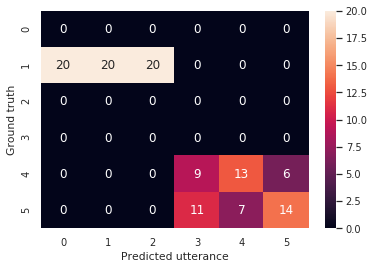

Accuracy: 0.39166666666666666


In [ ]:
plot_confusion_matrix(preds, lbls, [0,1,2,3,4,5])
# TODO replace [0,1,2,3,4,5] with list of emotions in correct order correspnding to emotions 

In [0]:
# TODO weighted accuracy, unweighted accuracy 